In [1]:
import pathlib
import os
import numpy as np
import matplotlib.pyplot as plt

from qec_util.performance import plots, confidence_interval_binomial
from qec_util.samplers import read_failures_from_file
from surface_sim.models import SI1000NoiseModel
from pymatching import Matching
from lomatching import MoMatching

In [2]:
import matplotlib
import matplotlib.ticker as ticker

matplotlib.rcParams.update(
    {
        "font.size": 11,
        "font.family": "cmr10",
        "font.weight": "normal",
        'axes.unicode_minus': False,
        "axes.formatter.use_mathtext": True,
        "text.usetex": True,
        "axes.formatter.limits": (0,0),
    }
)

def cm2inch(*tupl):
    inch = 2.54
    if isinstance(tupl[0], tuple):
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)

int_to_alph = {i: s for i, s in enumerate("abcdefghijklmnopqrstuvwxyz")}

In [3]:
# INPUTS
EXPERIMENTS = ["I"]
DISTANCES = [3, 5, 7]
PROBS_I  = [
    0.0002,
    0.0005,
    0.001,
    0.00116591,
    0.00135936,
    0.00158489,
    0.00184785,
    0.002,
    0.00215443,
    0.00251189,
    0.00292864,
    0.00341455,
    0.00398107,
    0.00464159,
    0.005,
    0.0054117,
    0.00630957,
    0.00735642,
    0.00857696,
    0.01,
]
NOISE_MODEL = SI1000NoiseModel
BASES = ["Z", "X"]
FRAMES = ["pre-gate"]
NUM_QEC_PER_GATE = 1
DECODER = MoMatching

# DATA STORAGE
NAME_FORMAT = "{exp_name}_{noise_model}_{decoder}_d{distance}_b{basis}_f{frame}_s0_ncycle-{ncycle}_p{prob:0.10f}.txt"
DATA_DIR = pathlib.Path(os.getcwd().replace("repeated-gate_experiments_splitting-hyperedge_decoder", "repeated-gate_experiments_lom_decoder")) / "data"
PLOTS_DIR = pathlib.Path("plots")

In [4]:
if not PLOTS_DIR.exists():
    PLOTS_DIR.mkdir()

In [5]:
NUM_FAILURES_I = np.zeros((len(EXPERIMENTS), len(BASES), len(FRAMES), len(DISTANCES), len(PROBS_I)))
NUM_SAMPLES_I = np.zeros((len(EXPERIMENTS), len(BASES), len(FRAMES), len(DISTANCES), len(PROBS_I)))

for i, experiment_name in enumerate(EXPERIMENTS):
    for j, basis in enumerate(BASES):
        for k, frame in enumerate(FRAMES):
            for l, distance in enumerate(DISTANCES):
                for m, prob in enumerate(PROBS_I):
                    file_name = NAME_FORMAT.format(
                       exp_name=experiment_name,
                       noise_model=NOISE_MODEL.__name__,
                       distance=distance,
                       basis=basis,
                       frame=frame,
                       prob=prob,                       
                       decoder=DECODER.__name__,       
                       ncycle=NUM_QEC_PER_GATE,
                    )

                    if not (DATA_DIR / file_name).exists():
                        print("MISSING --", DATA_DIR / file_name)
                        continue

                    try:
                        num_failures, num_samples, extra = read_failures_from_file(DATA_DIR / file_name)
                        NUM_FAILURES_I[i,j,k,l,m] = num_failures
                        NUM_SAMPLES_I[i,j,k,l,m] = num_samples
                    except:
                        print("BAD --", DATA_DIR / file_name)

LOG_PROB_I = NUM_FAILURES_I / NUM_SAMPLES_I
LOG_PROB_LOWER_I, LOG_PROB_UPPER_I = confidence_interval_binomial(NUM_FAILURES_I, NUM_SAMPLES_I)

In [6]:
print((NUM_SAMPLES_I != 0).sum())
assert (NUM_SAMPLES_I != 0).all()

120


In [7]:
# INPUTS
EXPERIMENTS = ["S", "CNOT-no-alternating"]
DISTANCES = [3, 5, 7]
PROBS  = [1e-05, 2e-05, 4e-05, 5e-05, 0.0001, 0.0002, 0.0005, 0.001, 0.002, 0.003, 0.005, 0.007, 0.01, 0.02, 0.05, 0.1]
NOISE_MODEL = SI1000NoiseModel
BASES = ["Z"]
FRAMES = ["pre-gate"]
DECODER = Matching

# DATA STORAGE
NAME_FORMAT = "{exp_name}_{noise_model}_{decoder}_d{distance}_b{basis}_f{frame}_s0_p{prob:0.10f}.txt"
DATA_DIR = pathlib.Path("data")

In [8]:
NUM_FAILURES = np.zeros((len(EXPERIMENTS), len(BASES), len(FRAMES), len(DISTANCES), len(PROBS)))
NUM_SAMPLES = np.zeros((len(EXPERIMENTS), len(BASES), len(FRAMES), len(DISTANCES), len(PROBS)))

for i, experiment_name in enumerate(EXPERIMENTS):
    for j, basis in enumerate(BASES):
        for k, frame in enumerate(FRAMES):
            for l, distance in enumerate(DISTANCES):
                for m, prob in enumerate(PROBS):
                    file_name = NAME_FORMAT.format(
                       exp_name=experiment_name,
                       noise_model=NOISE_MODEL.__name__,
                       distance=distance,
                       basis=basis,
                       frame=frame,
                       prob=prob,                       
                       decoder=DECODER.__name__,       
                    )

                    if not (DATA_DIR / file_name).exists():
                        print(DATA_DIR / file_name)
                        continue

                    num_failures, num_samples, extra = read_failures_from_file(DATA_DIR / file_name)
                    NUM_FAILURES[i,j,k,l,m] = num_failures
                    NUM_SAMPLES[i,j,k,l,m] = num_samples

LOG_PROB = NUM_FAILURES / NUM_SAMPLES
LOG_PROB_LOWER, LOG_PROB_UPPER = confidence_interval_binomial(NUM_FAILURES, NUM_SAMPLES)

In [9]:
print((NUM_SAMPLES != 0).sum())
assert (NUM_SAMPLES != 0).all()

96


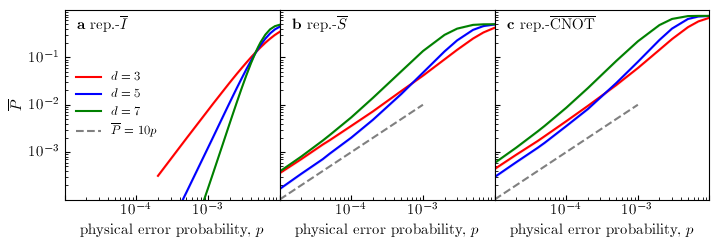

In [10]:
fig, axes = plt.subplots(ncols=3, figsize=cm2inch(18, 6))

# plot idling
i = 0
ax = axes[i]
color_distances_frame = [["red", "blue", "green", "purple"],]
for k, frame in enumerate(FRAMES):
    color_distances = color_distances_frame[k]
    for j, basis in enumerate(BASES):
        for l, distance in enumerate(DISTANCES):
            plots.plot_line_threshold(ax, PROBS_I, LOG_PROB_I[i,j,k,l], LOG_PROB_LOWER_I[i,j,k,l], LOG_PROB_UPPER_I[i,j,k,l], 
                                      linestyle="-" if basis == "Z" else "-.",
                                      color=color_distances[l], marker="none")
            
name = "rep.-$\\overline{I}$"

xmin, xmax = 1e-5, 1e-2

if "CNOT" not in experiment_name:
    ymin, ymax = 1e-4, 0.99999999
else:
    ymin, ymax = 1e-4, 0.99999999
ax.set_xlim(xmin, xmax)
ax.set_yticks([1e-2, 1e-1])
ax.set_ylim(ymin, ymax)
ax.text(xmin*1.5, ymax/2.5, f"\\textbf{{{int_to_alph[i]}}} {name}", horizontalalignment="left")

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylabel("$\\overline{P}$")
ax.tick_params(direction="in", which="major")
ax.tick_params(direction="in", which="minor")
ax.set_yticks([1e-1, 1e-2, 1e-3])
ax.set_ylim(1e-4, 1)
if i != 0:
    ax.set_ylabel("")
    ax.set_yticklabels([])
ax.set_xticks([1e-5, 1e-4, 1e-3, 1e-2])
ax.set_xticklabels(["", "$10^{-4}$", "$10^{-3}$", ""])


for i, experiment_name in enumerate(EXPERIMENTS):
    ax = axes[i+1]

    color_distances_frame = [["red", "blue", "green", "purple"],]
    for k, frame in enumerate(FRAMES):
        color_distances = color_distances_frame[k]
        for j, basis in enumerate(BASES):
            for l, distance in enumerate(DISTANCES):
                plots.plot_line_threshold(ax, PROBS, LOG_PROB[i,j,k,l], LOG_PROB_LOWER[i,j,k,l], LOG_PROB_UPPER[i,j,k,l], 
                                          linestyle="-" if basis == "Z" else "-.",
                                          color=color_distances[l], marker="none")

    i+=1
                
    if experiment_name == "CNOT-alternating":
        name = "rep.-alt.-$\\overline{\\mathrm{CNOT}}$"
    elif experiment_name == "CNOT-no-alternating":
        name = "rep.-$\\overline{\\mathrm{CNOT}}$"
    else:
        name = f"rep.-$\\overline{{{experiment_name}}}$"

    xmin, xmax = 1e-5, 1e-2

    if "CNOT" not in experiment_name:
        ymin, ymax = 1e-4, 0.99999999
    else:
        ymin, ymax = 1e-4, 0.99999999
    ax.set_xlim(xmin, xmax)
    ax.set_yticks([1e-2, 1e-1])
    ax.set_ylim(ymin, ymax)
    ax.text(xmin*1.5, ymax/2.5, f"\\textbf{{{int_to_alph[i]}}} {name}", horizontalalignment="left")

    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_ylabel("$\\overline{P}$")
    ax.tick_params(direction="in", which="major")
    ax.tick_params(direction="in", which="minor")
    ax.set_yticks([1e-1, 1e-2, 1e-3])
    ax.set_ylim(1e-4, 1)
    if i != 0:
        ax.set_ylabel("")
        ax.set_yticklabels([])
    ax.set_xticks([1e-5, 1e-4, 1e-3, 1e-2])
    ax.set_xticklabels(["", "$10^{-4}$", "$10^{-3}$", ""])

    PROBS_ = np.array(PROBS)
    PROBS_ = PROBS_[PROBS_<=1e-3]
    ax.plot(PROBS_, PROBS_*10, "--", color="gray")

color_distances = color_distances_frame[-1]
for l, distance in enumerate(DISTANCES):
    axes[0].plot([], [], linestyle="-", color=color_distances[l], label=f"$d = {distance}$")
axes[0].plot([], [], linestyle="--", color="gray", label="$\\overline{P} = 10p$")
axes[0].legend(loc="center left", frameon=False, fontsize=9)

fig.tight_layout(pad=0.30)
plt.subplots_adjust(wspace=.0)
fig.savefig(PLOTS_DIR / "threshold_plot_repeated_exp_circ-level-noise_matching_SI1000.pdf", format="pdf")
plt.show()